In [1]:
import os
import argparse
import requests
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    plot_confusion_matrix, 
    plot_roc_curve, 
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST, CIFAR10, CIFAR100

import timm

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

## Load MNIST Dataset

In [2]:
train_transform = T.Compose([
    T.ToTensor(), 
    T.RandomHorizontalFlip(0.5), 
    T.RandomRotation((-10, 10))
])
test_transform  = T.Compose([T.ToTensor()])
train_set = CIFAR10(root="/opt/datasets/cifar10", train=True,  transform=train_transform, download=True)
test_set  = CIFAR10(root="/opt/datasets/cifar10", train=False, transform=test_transform, download=True)
print(f"lenght of train set {len(train_set)}, test set {len(test_set)}")

Files already downloaded and verified
Files already downloaded and verified
lenght of train set 50000, test set 10000


In [3]:
batch_size = 2048
train_dl = DataLoader(train_set, batch_size, shuffle=True)
test_dl  = DataLoader(test_set,  batch_size, shuffle=False)

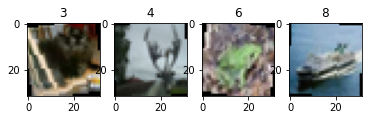

In [4]:
batch = next(iter(train_dl))
X = batch[0]
y = batch[1]

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(X[i].permute(1, 2, 0))
    ax[i].set_title(str(y[i].item()))
plt.show()

In [5]:
from pool import ActivePool
from methods import RandomSampling, UncertaintySampling, MarginSampling
from models import MNISTCNN

In [6]:
def get_model(num_classes:int):
    # model
    model = timm.create_model("resnet50", pretrained=False, num_classes=num_classes)
    return model

In [7]:
num_trials = 45
num_classes = len(train_set.classes)
max_epochs = 50
max_steps  = (50000 // 1024) * max_epochs
early_stopping_threshold = 0.95

query_size = 100

TRAIN_ACC = []
TEST_ACC  = []

model = get_model(num_classes).to(device)

pool = ActivePool(train_set, batch_size=1024)
init_sampler = RandomSampling(None, pool, query_size)
sampler = MarginSampling(model, pool, query_size)

result = init_sampler(size=5000)
pool.update(result)

for trial in range(num_trials):
    train_dl = pool.get_labeled_dataloader()
    eval_dl  = pool.get_unlabeled_dataloader()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.01)

    epochs = 0
    steps = 0
    training = True

    while training:
        
        all_targets = []
        all_preds = []

        model.train()
        for X, y in train_dl:
            optimizer.zero_grad()

            X = X.to(device)
            y = y.to(device)

            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(out, dim=1)
            all_preds.extend(pred.tolist())
            all_targets.extend(y.detach().cpu().tolist())

            steps += 1
            if steps > max_steps:
                training = False
                break

        acc = accuracy_score(all_targets, all_preds)
        TRAIN_ACC.append(acc)

        epochs += 1
        if acc > early_stopping_threshold:
            print(f"Early stopped at epoch {epochs+1} with accuracy score {acc:.3f}")
            break
    
    print(f"Trial {trial} Train accuracy: {acc:.3f}", end=" ")

    all_targets = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)

            out = model(X)
            loss = criterion(out, y)

            pred = torch.argmax(out, dim=1)
            all_preds.extend(pred.tolist())
            all_targets.extend(y.detach().cpu().tolist())
    
    acc = accuracy_score(all_targets, all_preds)
    TEST_ACC.append(acc)
    print(f"Test accuracy: {acc:.3f}")

    result = sampler()
    pool.update(result)
    print(f"Labeled pool updated with size {len(result.indices)}, time consumed {result.info['time']:.1f}s")

    print("Re-initialize the model")
    model = get_model(num_classes).to(device)
    sampler.update_model(model)

Trial 0 Train accuracy: 0.589 Test accuracy: 0.417
Labeled pool updated with size 100, time consumed 12.9s
Re-initialize the model
Trial 1 Train accuracy: 0.646 Test accuracy: 0.438
Labeled pool updated with size 100, time consumed 13.1s
Re-initialize the model


In [ ]:
plt.plot(TEST_ACC)